# Notebook Overview
### Testing effect of recurrance length on prediction performance

## Inputs
The input variables for the RNN's in this notebook are the following:

    1. Time series data -- Variable
    2. Additional predictors -- day_of_week, avg_employees, perc_hours_today_before,
       perc_hours_yesterday_before, perc_hours_tomorrow_before

## Model Architecture
The architecture used in this notebook combines an RNN with a feed forward neural network. The RNN layer recieves n days of lagged shift data and makes a prediction for the shift on the n+1th day. This prediction is then concatenated with the additional predictors and fed into a traditional neural network(various shapes, see log files for all tested archectures) to generate a better prediction--the idea being that the RNN (through it's long and short term memory) learns patterns over time and the FF network adjusts these patterns based on additional information. 




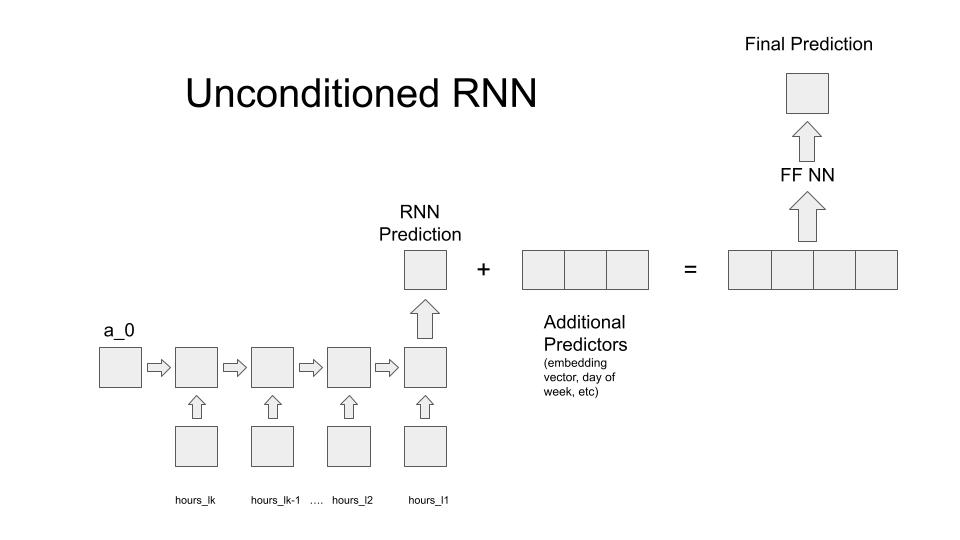

In [1]:
from IPython.display import Image
Image(filename="Images/Unconditioned_RNN_Diagram.jpeg")

In [1]:
#Logs hyperparameter specifications and other attributes of each run into a csv file
def log_model_info(model_info, path):
    try:
        df = pd.read_csv(path)
    except FileNotFoundError:
        #print(f"History csv not found at {path}. Creating new file.")
        df = pd.DataFrame()

    new_df = pd.DataFrame({k: [v] for k, v in model_info.items()})
    df = pd.concat([df, new_df], axis=0)
    df.to_csv(path, index=False)
    
#Expand categorical variables enumerated in labels to one-hot encodings
#Takes in pandas dataframe and returns tf tensor 
#Column ordering is preservered, with the convereted categorical columns dropped from the frame
#and their one-hot encodings concatenated to the end of the converted tensor
def expand_one_hot(labels,dataset):
    outList = []
    for label in labels:  
        col = dataset[label]
        ###Generate a dict for all unique values (Don't waste space encoding non important job id's)
        map = {}
        index = 0
        for element in col.unique():
            map[element] = index
            index += 1
        col = col.map(map)
        tensor = tf.one_hot(col,len(col.unique()))
        outList.append(tensor)
        dataset = dataset.drop(columns=[label])
    
    outList.insert(0,dataset)
    output = tf.concat(outList,1)
    return output

#Loads and preprocesses data from training_set.csv and crossvalidation_set.csv
def get_data():
    #nRows = 10000
    include_fields = ['hours','day_of_week','avg_employees','perc_hours_today_before',
                      'perc_hours_yesterday_before', 'perc_hours_tomorrow_before']
    for i in range(1,15):
        include_fields.append(f"hours_l{i}")
    
    train = pd.read_csv("/export/storage_adgandhi/PBJhours_ML/Data/Intermediate/train_test_validation/training_set.csv",usecols=include_fields).dropna()
    val = pd.read_csv("/export/storage_adgandhi/PBJhours_ML/Data/Intermediate/train_test_validation/crossvalidation_set.csv",usecols=include_fields).dropna()
    
    train_inputs, train_labels = train.drop(['hours'], axis=1), train.filter(['hours'])
    val_inputs, val_labels = val.drop(['hours'], axis=1), val.filter(['hours'])
    train_inputs = expand_one_hot(['day_of_week'],train_inputs)
    val_inputs = expand_one_hot(['day_of_week'],val_inputs)
    
    BUFFER_SIZE = 10000
    BATCH_SIZE = 256
    trainSet = tf.data.Dataset.from_tensor_slices((train_inputs,train_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    valSet = tf.data.Dataset.from_tensor_slices((val_inputs,val_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    return trainSet,valSet
    

In [2]:
import pandas as pd
import time
import datetime
import tensorflow as tf
from multiprocessing import Process

In [3]:
#RNN class, defines attributes of a model
class RNN(tf.keras.Model):
    #define all components of model
    def __init__(self,recurrance_length):
        super(RNN, self).__init__()
        self.recurrance_length = recurrance_length
        self.lstm = tf.keras.layers.LSTM(32)
        self.dense1 = tf.keras.layers.Dense(16, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(8, activation=tf.nn.relu)
        self.out = tf.keras.layers.Dense(1)
        self.batch_norm1 = tf.keras.layers.BatchNormalization()
        self.batch_norm2 = tf.keras.layers.BatchNormalization()
    
    #define model architecture
    def call(self, inputs, training=False):
        #prov_id is first column
        time_series = tf.reverse(tf.expand_dims(inputs[:,0:int(self.recurrance_length)],2),[1])
        additional_inputs = inputs[:,14:]

        x = self.lstm(time_series)
        x = tf.concat([x,additional_inputs],1)
        x = self.dense1(x)
        x = self.batch_norm1(x)
        x = self.dense2(x)
        x = self.batch_norm2(x)
        return self.out(x)


In [4]:
learning_rate = 1e-3
# Callback function to decrease learning rate
def decay(epoch):
  if epoch < 3:
    return learning_rate
  elif epoch >= 3 and epoch < 7:
    return learning_rate/10
  else:
    return learning_rate/100

# base dict of values to log for each run. Some values are common to every run
base_dict = {'Recurrance length':-1,'LSTM Units':32,'Embedding Dimension':0,'FF model shape':[16,8,1],'Initial Learning Rate':learning_rate,'Regularization':"Batch Normalization",'Metric':"mse",'Training loss':-1,'Val loss':-1,
             'time_start':-1,'time_duration':-1,'Epochs':10,'Columns':['day_of_week','avg_employees','perc_hours_today_before',
             'perc_hours_yesterday_before', 'perc_hours_tomorrow_before'],'LSTM type':"Unconditioned",'user':"asharma"}

# Worker function for multiprocessing Process. Trains an RNN with the specified recurrance length
def train_and_test_models(recurrance_length,garb):
    print(f"Started process with recurrance length: {recurrance_length}")
    trainSet,valSet = get_data()
    start_time = time.time()
    start_date = datetime.datetime.now()
    model = RNN(recurrance_length)
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[tf.keras.metrics.MeanAbsoluteError()])
    callbacks = [
    tf.keras.callbacks.LearningRateScheduler(decay)
    ]
    #print("CHECKPOINT 2")
    #print(trainSet)
    history = model.fit(trainSet, epochs=10, callbacks=callbacks, validation_data=valSet,verbose=0)
    #print("CHECKPOINT 3")
    valLoss, metric = model.evaluate(valSet)
    #print("CHECKPOINT 4")
    param_dict = base_dict.copy()
    time_taken = str(datetime.timedelta(seconds=(time.time()-start_time)))
    train_loss = history.history['loss'][9]
    param_dict['Recurrance length'] = recurrance_length
    param_dict['Training loss'] = train_loss
    param_dict['Val loss'] = valLoss
    param_dict['time_start'] = start_date
    param_dict['time_duration'] = time_taken
    log_model_info(param_dict,'/users/facsupport/asharma/RNN-shifts/rnn_tuning_history.csv')
    print("COMPLETED WORK")

In [ ]:
lengths = [3,7,10,14]
tasks = []
for i in range(len(lengths)):
    tasks.append(Process(target=train_and_test_models,args=(lengths[i],0)))
    tasks[i].start()
for i in range(len(lengths)):
    tasks[i].join()

Started process with recurrance length: 3
Started process with recurrance length: 7
Started process with recurrance length: 10
Started process with recurrance length: 14


In [24]:
data = pd.read_csv('/users/facsupport/asharma/RNN-shifts/rnn_tuning_history.csv')